## 1. Setup & Data Loading

In [1]:
import warnings
warnings.filterwarnings('ignore')

import importlib
import src.visualization
import src.woe_binning
import src.scorecard
import src.metrics
importlib.reload(src.visualization)
importlib.reload(src.woe_binning)
importlib.reload(src.scorecard)
importlib.reload(src.metrics)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src import (
    load_and_prepare_data, split_data, get_data_summary, combine_train_val,
    TARGET_PD, BASE_SCORE, PDO, RANDOM_STATE,
)

In [2]:
DATA_PATH = 'zbior_10.csv'
TARGET_COL = 'default'

df = pd.read_csv(DATA_PATH)
print(f"Dataset shape: {df.shape}")
print(f"Target distribution:\n{df[TARGET_COL].value_counts(normalize=True)}")

Dataset shape: (3000, 220)
Target distribution:
default
0    0.939
1    0.061
Name: proportion, dtype: float64


In [3]:
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y, test_size=0.2, val_size=0.2)
print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Train: 1800, Val: 600, Test: 600


## 2. Exploratory Data Analysis

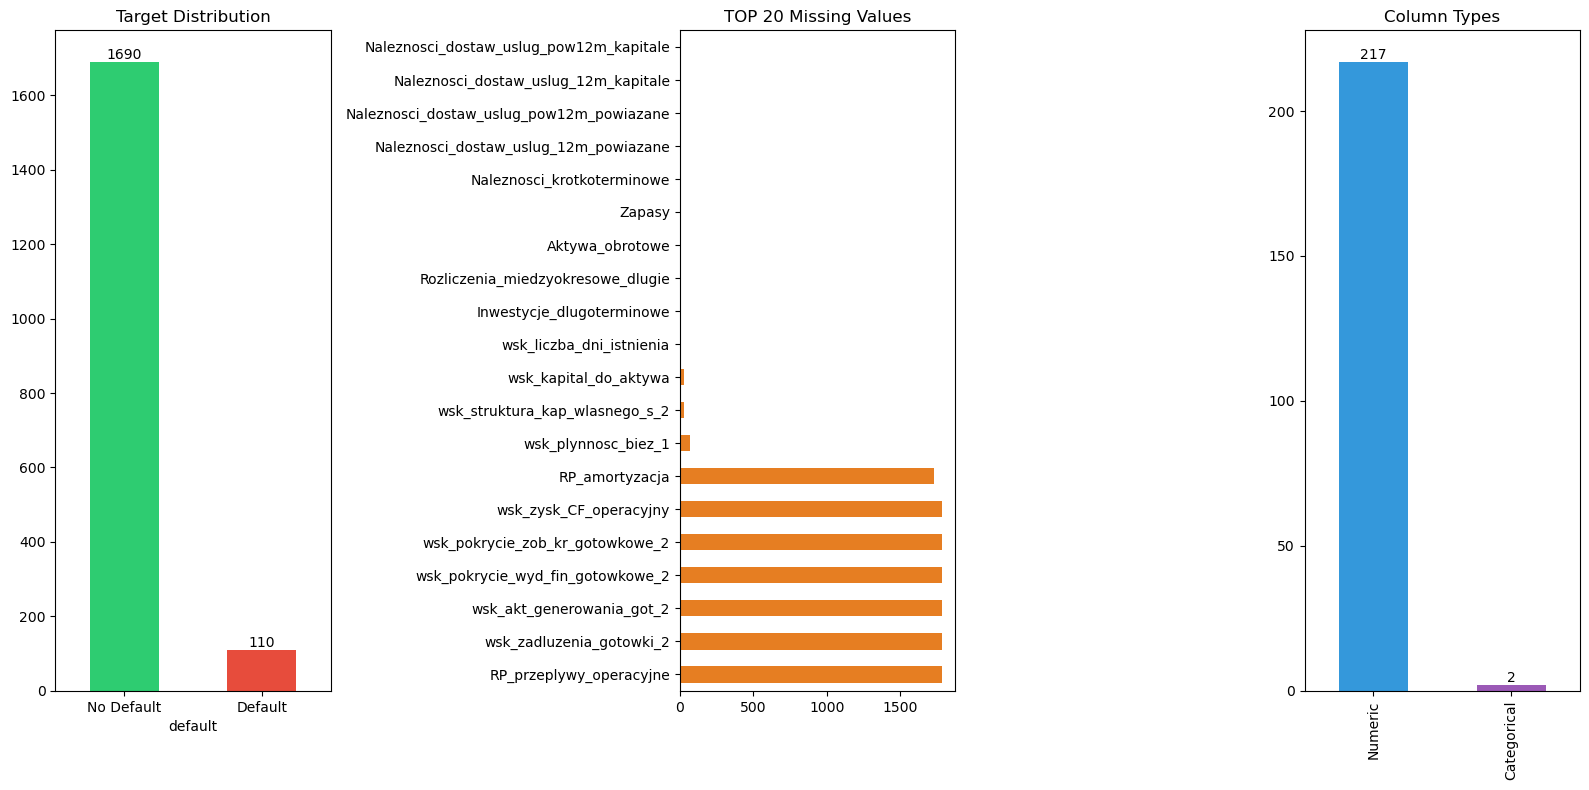

In [4]:
from src import plot_data_overview, plot_correlation_matrix, plot_target_correlation

fig = plot_data_overview(X_train, y_train)
plt.show()

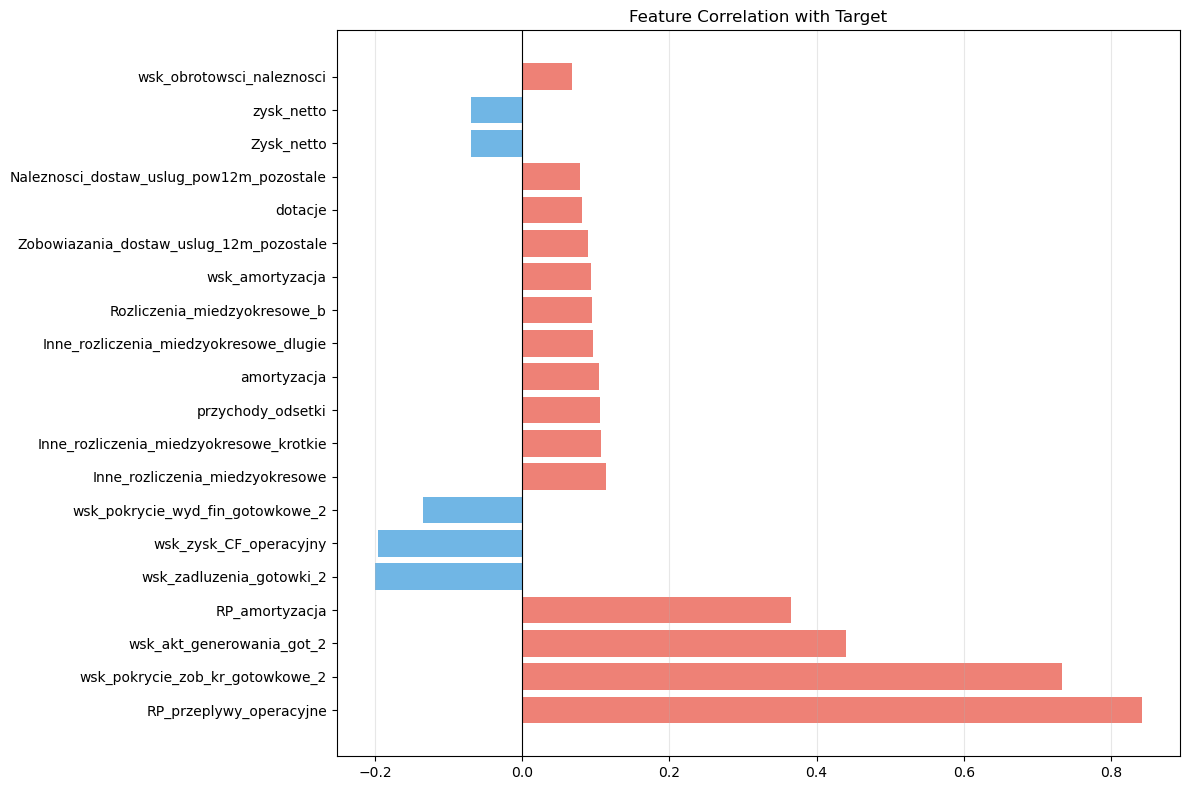

In [5]:
fig, corr_df = plot_target_correlation(X_train, y_train, top_n=20)
plt.show()

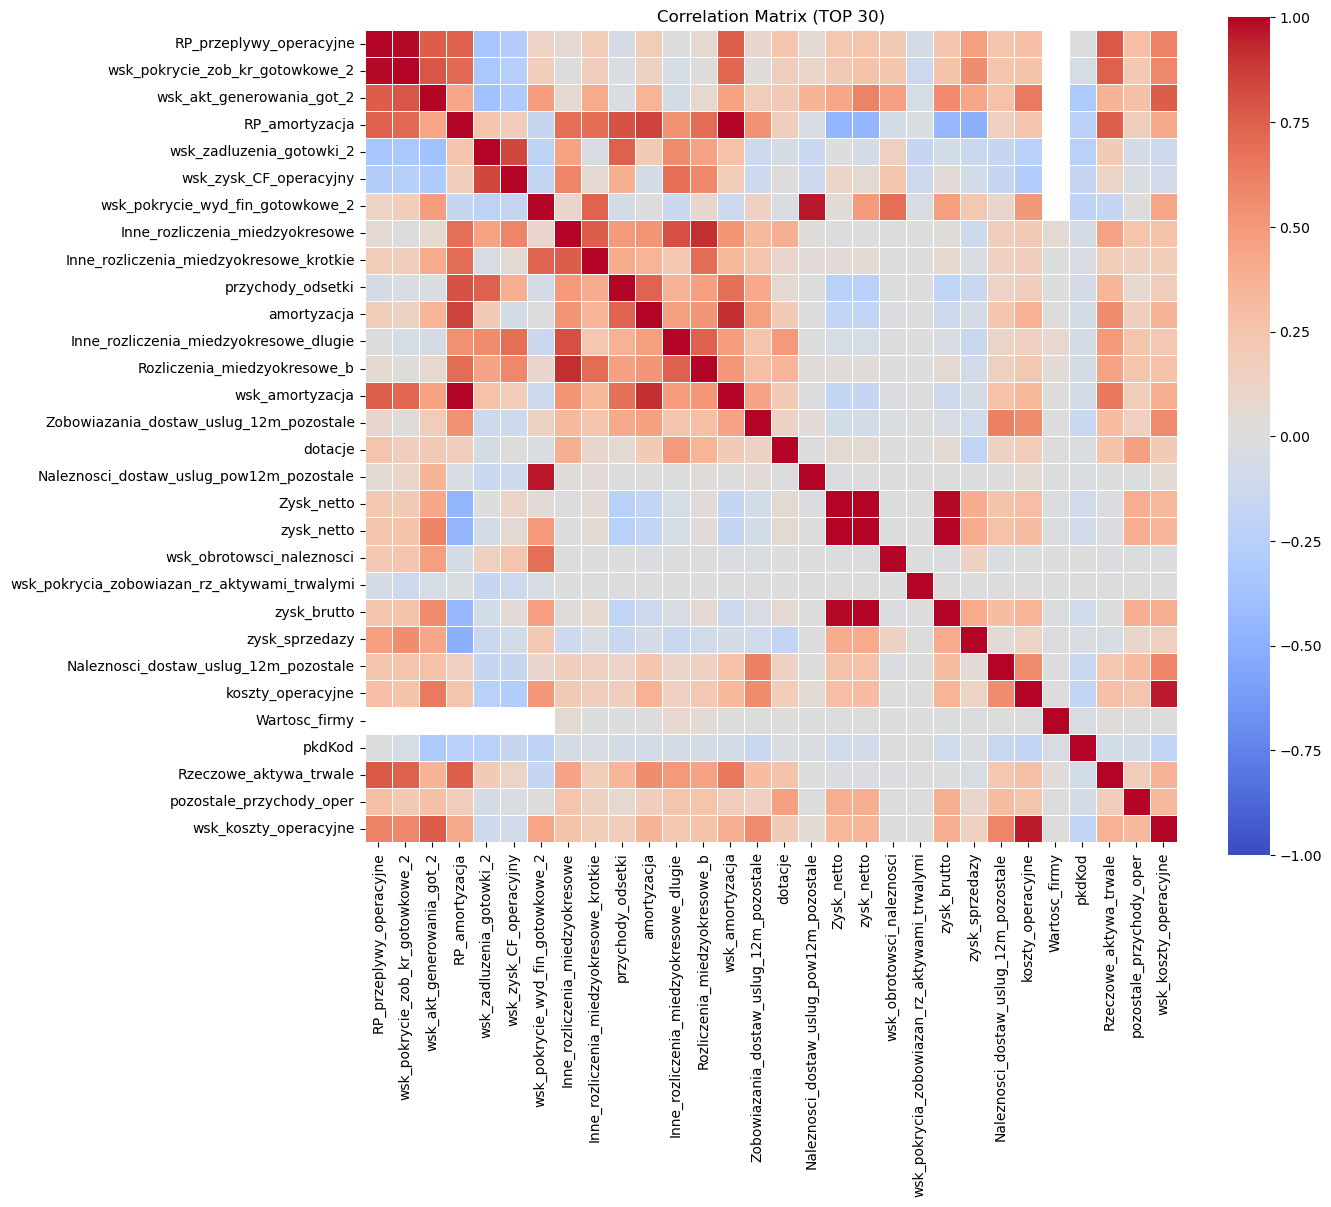

In [6]:
fig, corr_matrix = plot_correlation_matrix(X_train, y_train, top_n=30)
plt.show()

## 3. Preprocessing (PRODUCTION Pipeline)

In [4]:
from src import InterpretablePreprocessingPipeline

pipeline = InterpretablePreprocessingPipeline()
X_train_processed = pipeline.fit_transform(X_train, y_train)
X_val_processed = pipeline.transform(X_val)
X_test_processed = pipeline.transform(X_test)

print(f"Features after preprocessing: {X_train_processed.shape[1]}")

Features after preprocessing: 102


## 4. WoE/IV Feature Analysis

In [5]:
from src import calculate_iv_for_selection, select_features_by_iv, plot_iv_ranking, interpret_iv

iv_df = calculate_iv_for_selection(X_train_processed, y_train)
iv_df['Power'] = iv_df['IV'].apply(interpret_iv)
iv_df.head(20)

,Feature,IV,Power
0,wsk_mnoznik_kap_wl,0.587405,Suspicious
1,wsk_udzial_kap_wlasnego_aktywa_1,0.585497,Suspicious
2,wsk_struktury_kapitalu,0.570801,Suspicious
3,wsk_zadluzenie_kap_wlasnego,0.520780,Suspicious
4,wsk_udzial_zob_biez_aktywa_1,0.519769,Suspicious
5,wsk_rent_kapitalu,0.494725,Strong
6,wsk_efekt_dzwigni_fin_1,0.493972,Strong
7,wsk_obrotowosc_gotowkowa,0.458634,Strong
8,wsk_marza_ebitda_3,0.449474,Strong
9,zysk_sprzedazy,0.443244,Strong


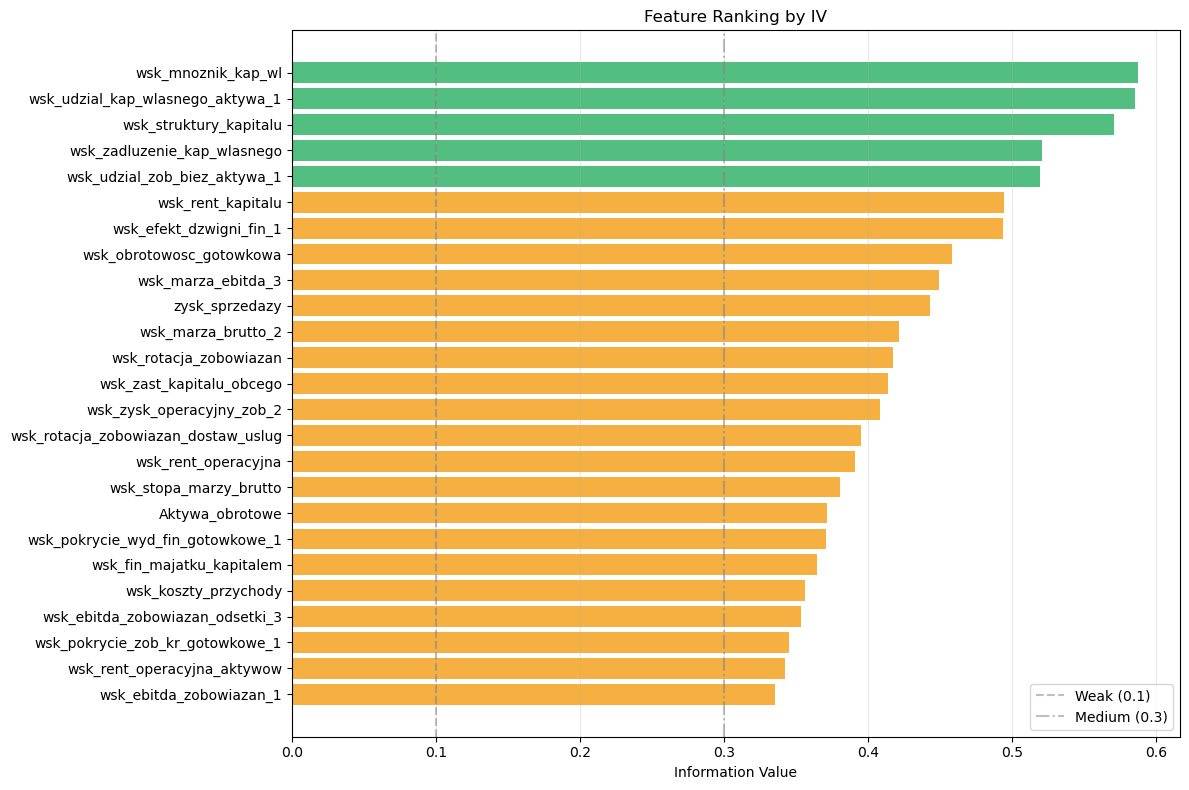

In [6]:
fig = plot_iv_ranking(iv_df, top_n=25)
plt.show()

In [7]:
selected_features = select_features_by_iv(iv_df, min_iv=0.02)
print(f"Selected {len(selected_features)} features with IV >= 0.02")

X_train_selected = X_train_processed[selected_features]
X_val_selected = X_val_processed[selected_features]
X_test_selected = X_test_processed[selected_features]

Selected 93 features with IV >= 0.02


## 5. Scorecard Model Training

In [8]:
from src import CreditScorecard, calculate_all_metrics

scorecard = CreditScorecard(base_score=BASE_SCORE, pdo=PDO)
scorecard.fit(X_train_selected, y_train)

y_proba_train = scorecard.predict_proba(X_train_selected)
y_proba_val = scorecard.predict_proba(X_val_selected)
y_proba_test = scorecard.predict_proba(X_test_selected)

In [9]:
train_metrics = calculate_all_metrics(y_train, y_proba_train)
val_metrics = calculate_all_metrics(y_val, y_proba_val)
test_metrics = calculate_all_metrics(y_test, y_proba_test)

pd.DataFrame({'Train': train_metrics, 'Val': val_metrics, 'Test': test_metrics})

,Train,Val,Test
accuracy,0.939444,0.940000,0.938333
precision,0.666667,0.000000,0.000000
recall,0.018182,0.000000,0.000000
f1,0.035398,0.000000,0.000000
roc_auc,0.815355,0.645242,0.626206
pr_auc,0.261278,0.089134,0.088148
ks_statistic,0.503981,0.261820,0.283136
gini,0.630710,0.290485,0.252412
log_loss,0.188174,0.235169,0.246607
brier_score,0.051273,0.057938,0.060041


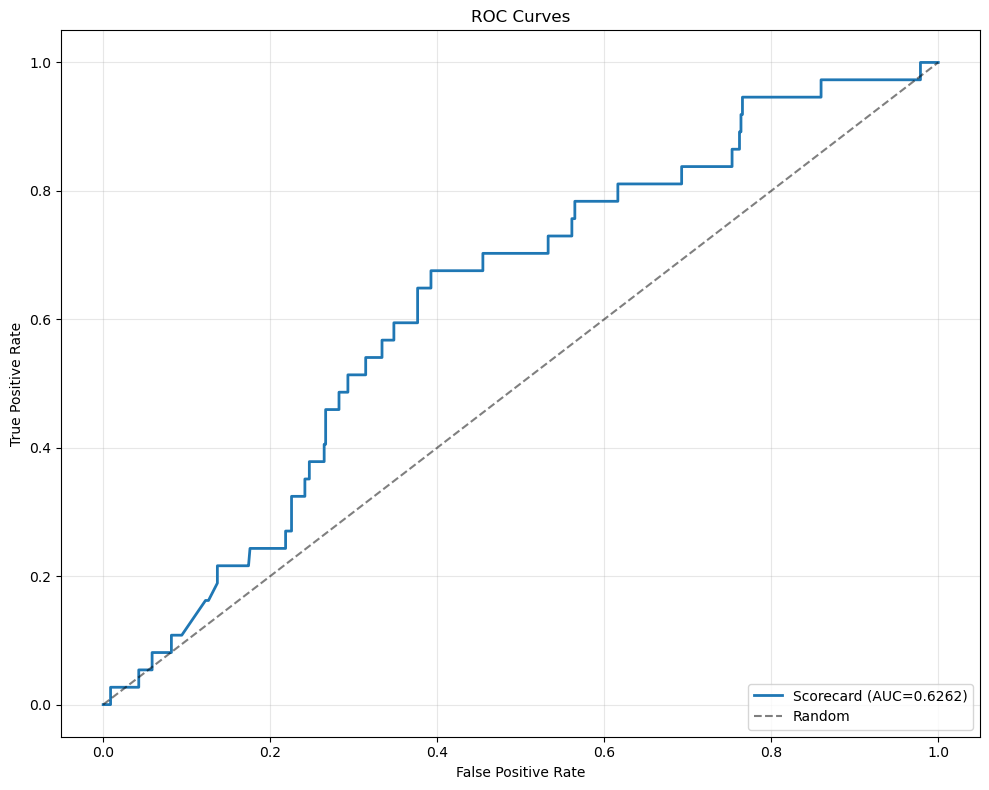

In [10]:
from src import plot_roc_curves, plot_score_distribution

proba_dict = {'Train': y_proba_train, 'Val': y_proba_val, 'Test': y_proba_test}
fig = plot_roc_curves(y_test, {'Scorecard': y_proba_test})
plt.show()

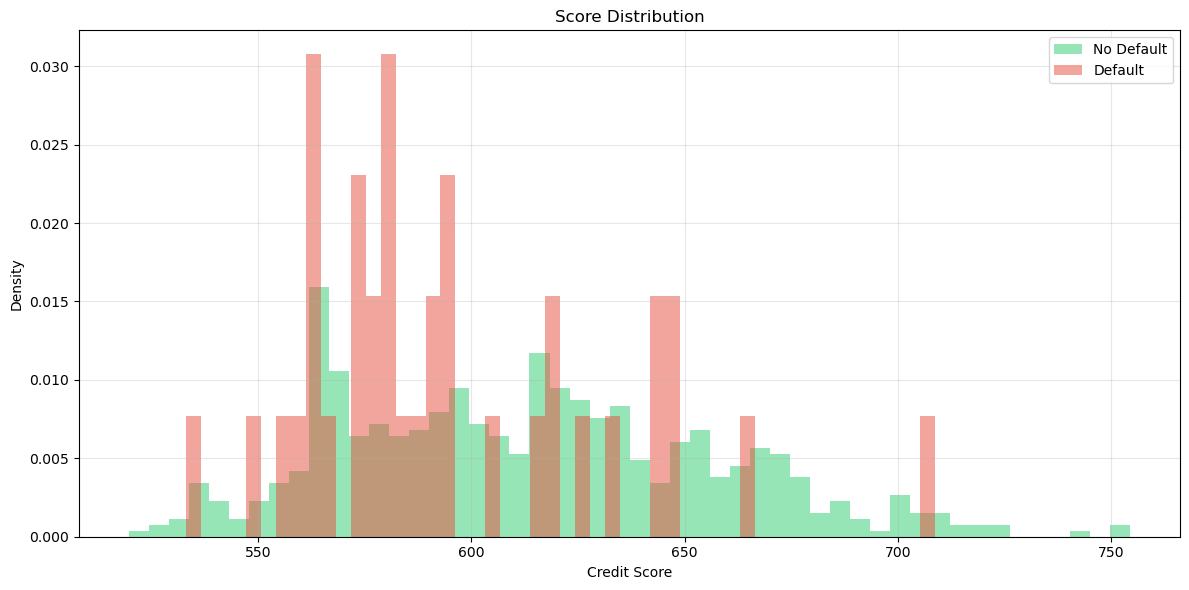

In [11]:
scores_test = scorecard.predict_score(X_test_selected)
fig = plot_score_distribution(scores_test, y_test)
plt.show()

## 6. Probability Calibration

In [ ]:
from src import (
    CalibrationModule, plot_calibration_curves, plot_calibration_histogram,
    plot_calibration_diagnostic, plot_calibration_comparison
)

calibrator = CalibrationModule(target_pd=TARGET_PD)

calibrator.fit_platt(y_val, y_proba_val)
calibrator.fit_isotonic(y_val, y_proba_val)
calibrator.fit_beta(y_val, y_proba_val)
calibrator.fit_intercept(y_proba_val)

print("Calibrators fitted: Platt, Isotonic, Beta, Intercept")

Mean PD before calibration: 0.0570
Mean PD after calibration: 0.0603
Target PD: 0.04


In [ ]:
fig, pre_cal_metrics = plot_calibration_diagnostic(y_val, y_proba_val, n_bins=10)
plt.suptitle('Pre-Calibration Diagnostic (Validation Set)', fontsize=14, y=1.02)
plt.show()

print("\nPre-Calibration Metrics:")
for k, v in pre_cal_metrics.items():
    print(f"  {k}: {v:.4f}")

In [ ]:
y_platt = calibrator.transform(y_proba_test, method='platt')
y_isotonic = calibrator.transform(y_proba_test, method='isotonic')
y_beta = calibrator.transform(y_proba_test, method='beta')
y_intercept = calibrator.transform(y_proba_test, method='intercept')

calib_methods = {
    'Uncalibrated': y_proba_test,
    'Platt Scaling': y_platt,
    'Isotonic Regression': y_isotonic,
    'Beta Calibration': y_beta,
}

fig, calib_metrics = plot_calibration_comparison(y_test, calib_methods, n_bins=10)
plt.suptitle('Calibration Methods Comparison (Test Set)', fontsize=14, y=1.02)
plt.show()

calib_metrics

In [ ]:
best_method = calib_metrics['ECE'].idxmin()
print(f"Best calibration method by ECE: {best_method}")

y_proba_calibrated = calib_methods[best_method]
print(f"\nMean PD before calibration: {y_proba_test.mean():.4f}")
print(f"Mean PD after {best_method}: {y_proba_calibrated.mean():.4f}")
print(f"Target PD: {TARGET_PD}")

## 7. Blackbox Models Comparison

In [ ]:
from src import train_xgboost_bayesian, train_lightgbm_bayesian, train_random_forest, compare_models

X_train_full = combine_train_val(X_train_selected, X_val_selected)
y_train_full = pd.concat([y_train, y_val])

In [ ]:
xgb_model = train_xgboost_bayesian(X_train_full, y_train_full, n_iter=20)
y_proba_xgb = xgb_model.predict_proba(X_test_selected)[:, 1]

In [ ]:
lgb_model = train_lightgbm_bayesian(X_train_full, y_train_full, n_iter=20)
y_proba_lgb = lgb_model.predict_proba(X_test_selected)[:, 1]

In [ ]:
rf_model = train_random_forest(X_train_full, y_train_full)
y_proba_rf = rf_model.predict_proba(X_test_selected)[:, 1]

In [ ]:
from src import plot_model_comparison

all_proba = {
    'Scorecard': y_proba_test,
    'XGBoost': y_proba_xgb,
    'LightGBM': y_proba_lgb,
    'RandomForest': y_proba_rf
}

comparison_df = compare_models(y_test, all_proba)
comparison_df

In [ ]:
fig = plot_roc_curves(y_test, all_proba)
plt.show()

## 8. Model Interpretation

In [ ]:
from src import decompose_log_odds, plot_waterfall_log_odds, plot_coefficient_importance

coef_df = scorecard.get_coefficient_table()
fig = plot_coefficient_importance(coef_df, top_n=20)
plt.show()

In [ ]:
from src import select_representative_cases, analyze_case_study

cases = select_representative_cases(y_test, y_proba_test, n_per_type=2)
cases

In [ ]:
idx = cases['high_risk'].iloc[0]
contributions = decompose_log_odds(scorecard.model, X_test_selected.iloc[[idx]])
fig = plot_waterfall_log_odds(
    contributions[0], 
    X_test_selected.columns.tolist(),
    scorecard.model.intercept_[0],
    y_proba_test[idx]
)
plt.show()

In [ ]:
from src import get_shap_values, plot_shap_summary

try:
    shap_values = get_shap_values(xgb_model, X_test_selected.iloc[:500])
    fig = plot_shap_summary(shap_values, X_test_selected.iloc[:500])
    plt.show()
except ImportError:
    print("SHAP not installed. Install with: pip install shap")

## 9. Rating Mapping & Threshold Analysis

In [ ]:
from src import (
    map_pd_to_rating, analyze_rating_distribution, 
    find_optimal_threshold, compare_all_thresholds,
    plot_rating_distribution, plot_threshold_analysis
)

ratings = map_pd_to_rating(y_proba_calibrated)
rating_dist = analyze_rating_distribution(ratings)
rating_dist

In [ ]:
fig = plot_rating_distribution(rating_dist)
plt.show()

In [ ]:
threshold_comparison = compare_all_thresholds(y_test, y_proba_calibrated)
threshold_comparison

In [ ]:
optimal_thresholds = {row.Index: row.threshold for row in threshold_comparison.itertuples()}
fig = plot_threshold_analysis(y_test, y_proba_calibrated, optimal_thresholds)
plt.show()

In [ ]:
from src import plot_gains_chart, plot_lift_chart

fig = plot_gains_chart(y_test, y_proba_calibrated)
plt.show()

In [ ]:
fig = plot_lift_chart(y_test, y_proba_calibrated)
plt.show()

## Summary

This notebook demonstrates a complete credit scoring pipeline:

1. **Data**: Loaded and split into train/val/test
2. **EDA**: Visualized target distribution and correlations
3. **Preprocessing**: Applied PRODUCTION pipeline (InterpretablePreprocessingPipeline)
4. **WoE/IV**: Analyzed feature importance via Information Value
5. **Scorecard**: Trained interpretable logistic regression model
6. **Calibration**: Adjusted probabilities to target PD of 4%
7. **Blackbox**: Compared with XGBoost, LightGBM, RandomForest
8. **Interpretation**: Log-odds decomposition, SHAP values
9. **Rating**: Mapped PD to credit ratings (AAA-D), optimized thresholds